# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [2]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [3]:
max_iterations = 50
loop_count = 13

In [4]:

dev_1 = qml.device('default.qubit', wires=1)
dev_2 = qml.device('default.qubit', wires=1)
dev_3 = qml.device('default.qubit', wires=1)

## Classifier 1
weights_count = 3
init_weights_1 = (0.01 * np.random.randn(weights_count), 0.0)

print(init_weights_1)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
weights_count = 6
init_weights_2 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
weights_count = 6
init_weights_3 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RX(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


(tensor([ 0.00566774,  0.00092334, -0.00374709], requires_grad=True), 0.0)


In [5]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)
      # print("trained weights and bias (var):", var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6536891 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5598978 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4498472 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3368032 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2280503 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.1364179 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.0795028 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     8 | Cost: 1.0486352 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.0298285 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0198191 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0147463 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3973432 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3787078 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3473228 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.3027715 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2540534 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2030081 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.1421093 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0933376 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.0329123 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.9839597 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.9387395 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6911953 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6386366 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5730500 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5025533 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4246515 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.3387667 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2418457 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.1539618 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0733831 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:    10 | Cost: 0.9772535 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    11 | Cost: 0.8882033 | Acc trai

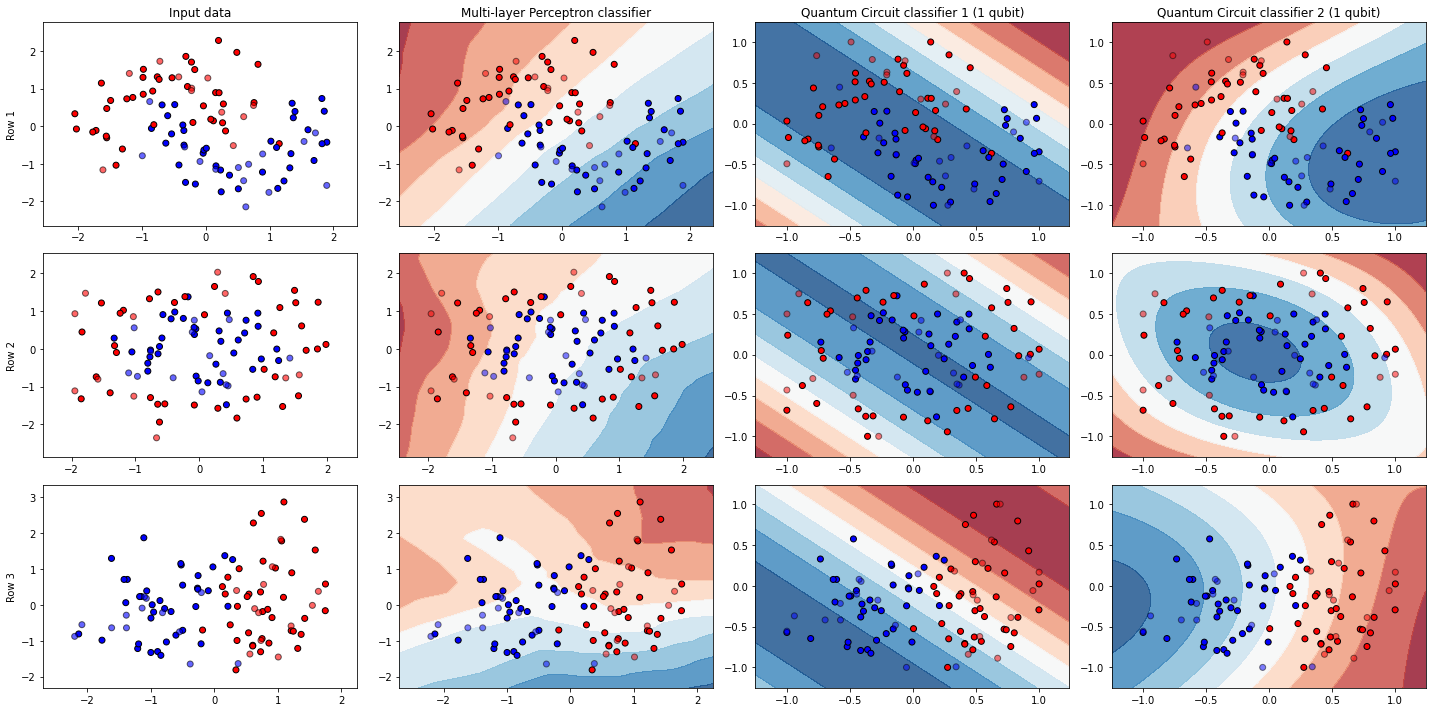

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6735455 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6391268 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5616157 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4859067 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4144234 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3475766 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2829770 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2337129 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.1821593 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.1390937 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.1065006 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3920143 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3618372 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3138151 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2472451 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1680142 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0899235 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0236348 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9713742 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9242253 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8854673 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8587170 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6714247 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5744472 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4657563 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.3436378 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2291256 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1282648 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0313214 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9485935 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.8718981 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8177507 | Acc train: 0.6400000 | Acc val: 0.8000000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.7848777 | Acc trai

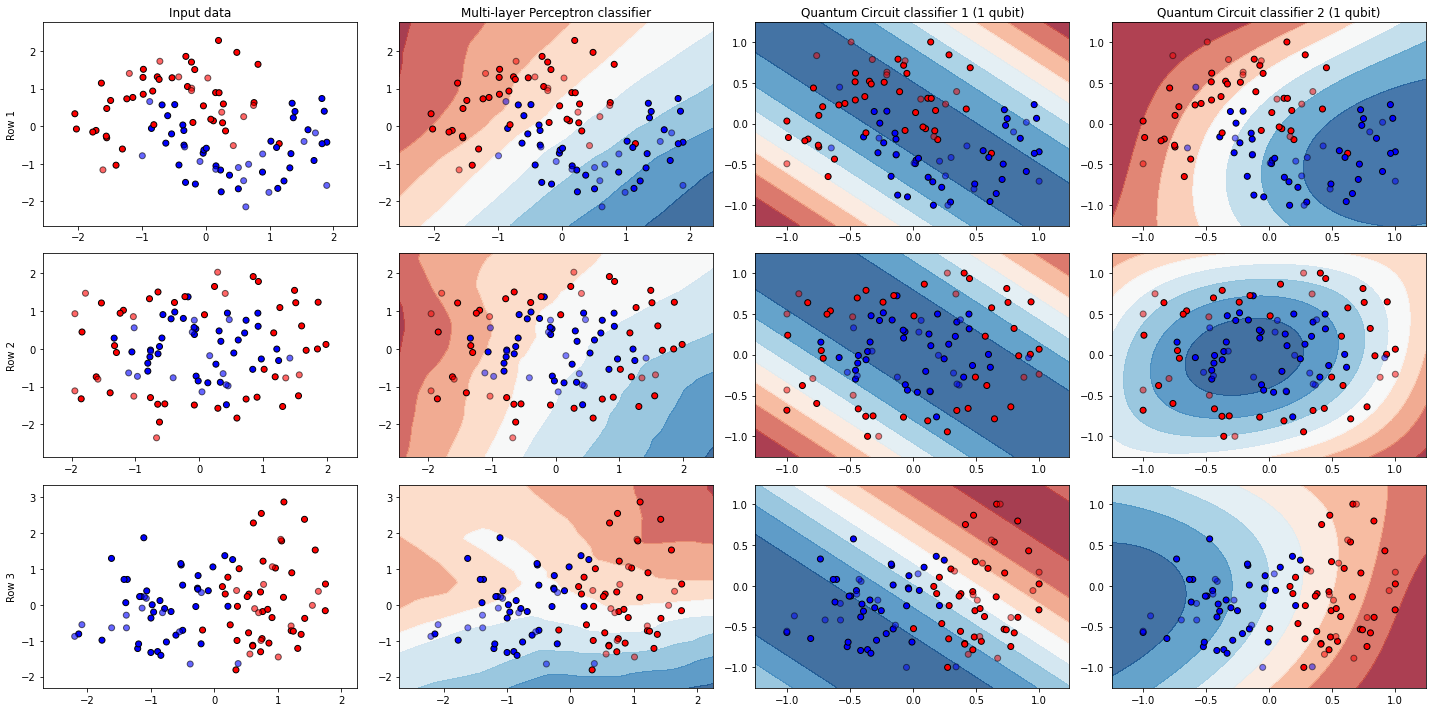

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6743131 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6087927 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5164411 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4230981 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3413114 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2593087 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.1918271 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1379068 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1020057 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0746706 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.0631364 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3938558 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3558221 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3121811 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2378504 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1630684 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0959718 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0271333 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9711755 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9310757 | Acc train: 0.6400000 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.9062257 | Acc train: 0.6533333 | Acc val: 0.6400000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8892738 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6602204 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5370972 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4180928 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2971561 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     5 | Cost: 1.1921800 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0737718 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     7 | Cost: 0.9542238 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     8 | Cost: 0.8428824 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:     9 | Cost: 0.7491916 | Acc train: 0.6666667 | Acc val: 0.8800000 | Acc all: 0.6900000 
Iter:    10 | Cost: 0.6997543 | Acc train: 0.7466667 | Acc val: 0.8400000 | Acc all: 0.7800000 
Iter:    11 | Cost: 0.6951655 | Acc trai

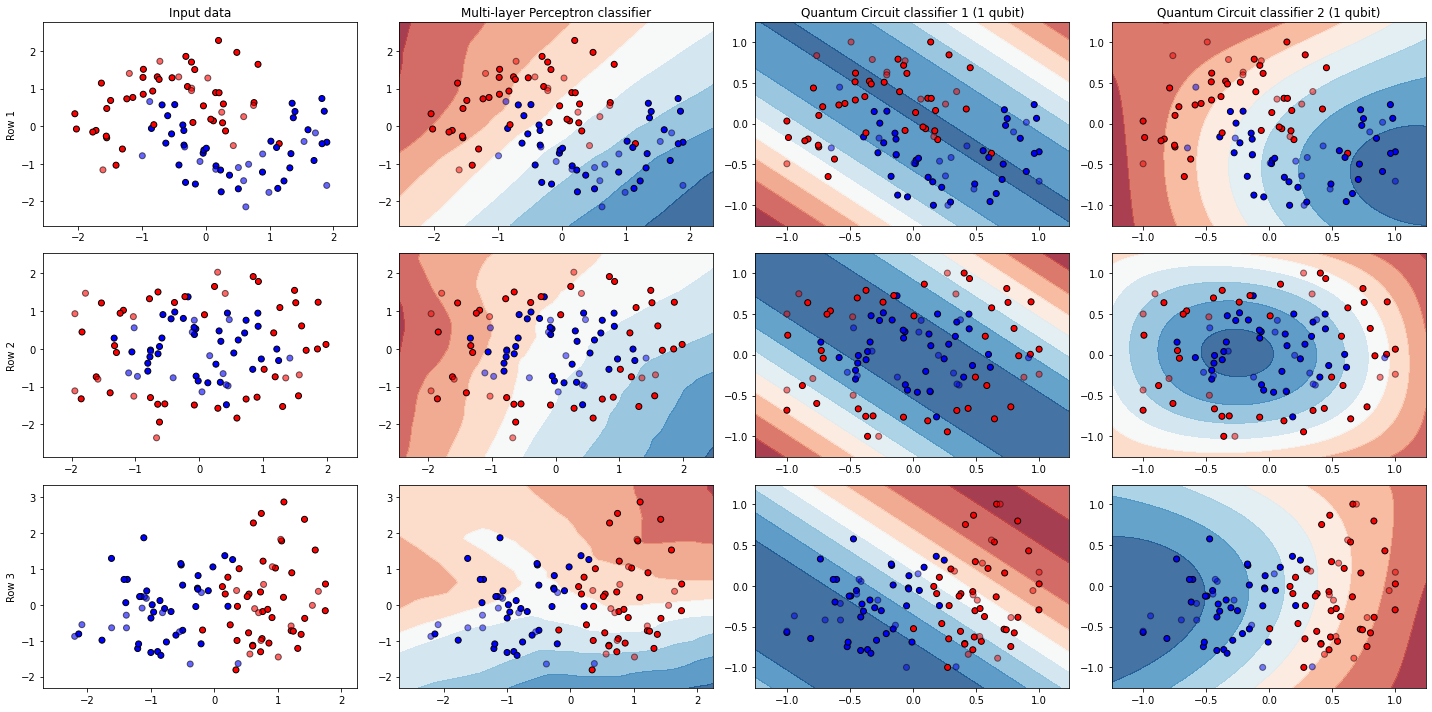

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6753133 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6348055 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5550396 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4719309 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3803171 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2992476 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2144128 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1371038 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.0787307 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.0459283 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0327002 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3839905 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3243636 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2690807 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2017959 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1331737 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0784440 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0273637 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9696789 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9205248 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8829301 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.8580136 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7088007 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6682643 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6064929 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5267280 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4237573 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2970771 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.1727528 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0698909 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9635653 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8700715 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.7924783 | Acc trai

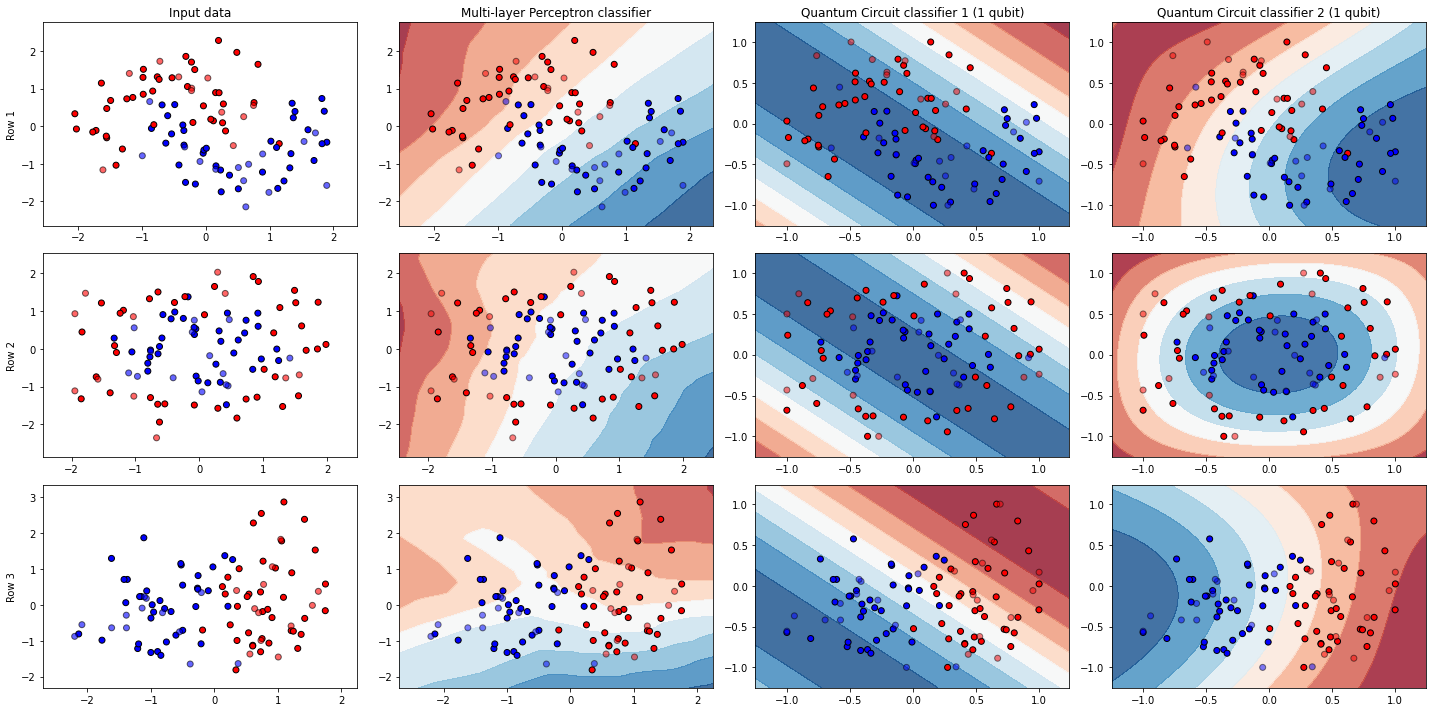

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6837427 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6454550 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6039930 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5433606 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4813238 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3937328 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3215375 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2443760 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.1731662 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.1122877 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0637654 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3879111 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3309456 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2514686 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.1661507 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     5 | Cost: 1.0791958 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0132225 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     7 | Cost: 0.9659396 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:     8 | Cost: 0.9182218 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6500000 
Iter:     9 | Cost: 0.8887835 | Acc train: 0.6800000 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8670309 | Acc train: 0.6666667 | Acc val: 0.6800000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8527963 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6766883 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5932891 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4874025 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.3624333 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2469156 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.1423489 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0492216 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9753691 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9218893 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8630852 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8067733 | Acc trai

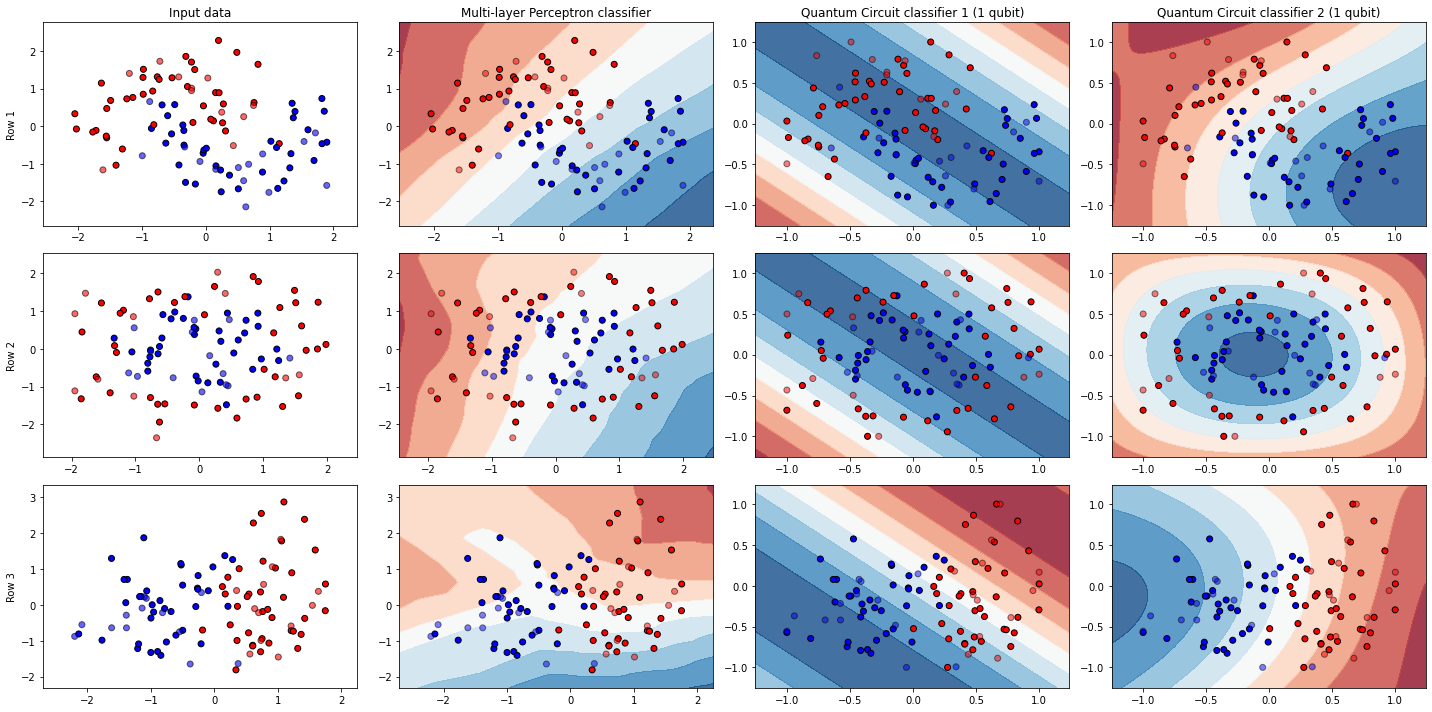

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6688682 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6195101 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5293834 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4339485 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3412844 | Acc train: 0.4666667 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.2507066 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.1686306 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1034481 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.0547868 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.4900000 
Iter:    10 | Cost: 1.0230111 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.4700000 
Iter:    11 | Cost: 1.0014332 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4149514 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3854647 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3341544 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2770162 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2106845 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1303539 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0607142 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9975052 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9429830 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9027329 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8662183 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6864752 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.6024853 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5011305 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4053590 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3085142 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.2017315 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.0990254 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0094184 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9251467 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.8576147 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8136280 | Acc trai

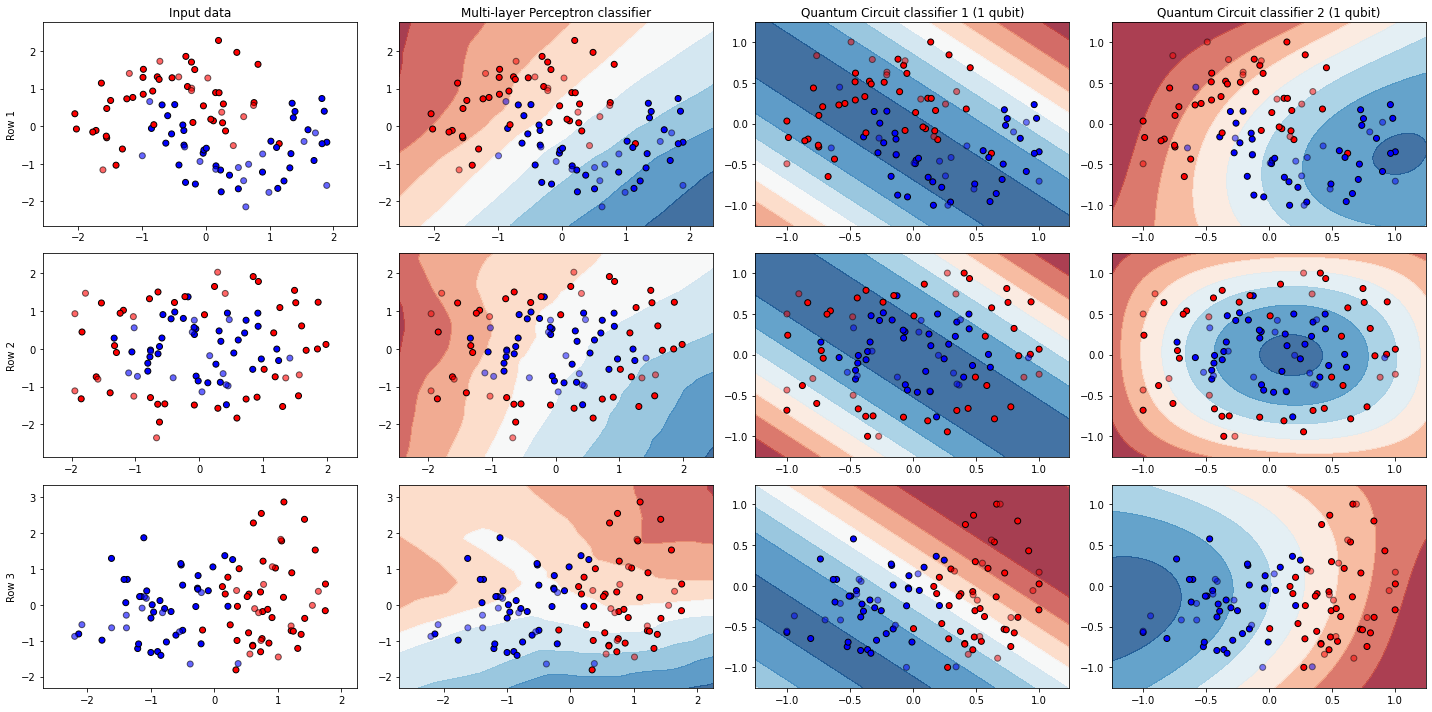

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6706441 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5970080 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5091381 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4318936 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.4900000 
Iter:     5 | Cost: 1.3444755 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2691398 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.1886746 | Acc train: 0.4933333 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1143223 | Acc train: 0.4666667 | Acc val: 0.5600000 | Acc all: 0.4500000 
Iter:     9 | Cost: 1.0656857 | Acc train: 0.4533333 | Acc val: 0.6000000 | Acc all: 0.4700000 
Iter:    10 | Cost: 1.0305170 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    11 | Cost: 1.0102377 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3925953 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3361719 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2749254 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2164459 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1457322 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0948465 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0476783 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.0010969 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9507486 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.9144804 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8889406 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7114172 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6593060 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5871812 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4571175 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.3251503 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.1863460 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0500016 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9305872 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8294886 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7526866 | Acc train: 0.6666667 | Acc val: 0.8400000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.6933121 | Acc trai

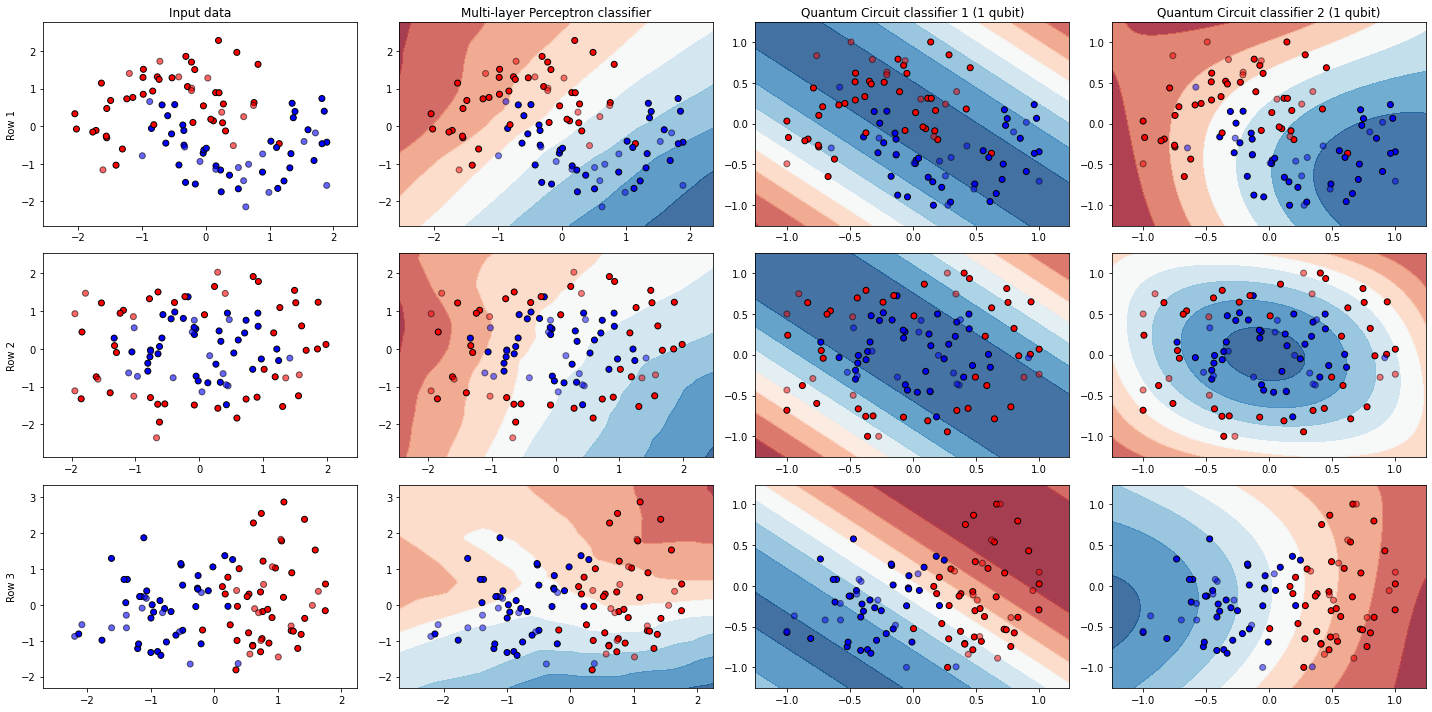

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6688672 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6015166 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5349356 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4445036 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3667477 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2907603 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2204301 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1633818 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.1146409 | Acc train: 0.6000000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0783577 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.0541369 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4176646 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3941639 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3383768 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2798159 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2257269 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.1579631 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0893315 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0157650 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.9524800 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.9042936 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8678343 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6997244 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6385381 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5737014 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5035952 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.4087787 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.3142340 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.2129158 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.1029921 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9787110 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8588310 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.7665001 | Acc trai

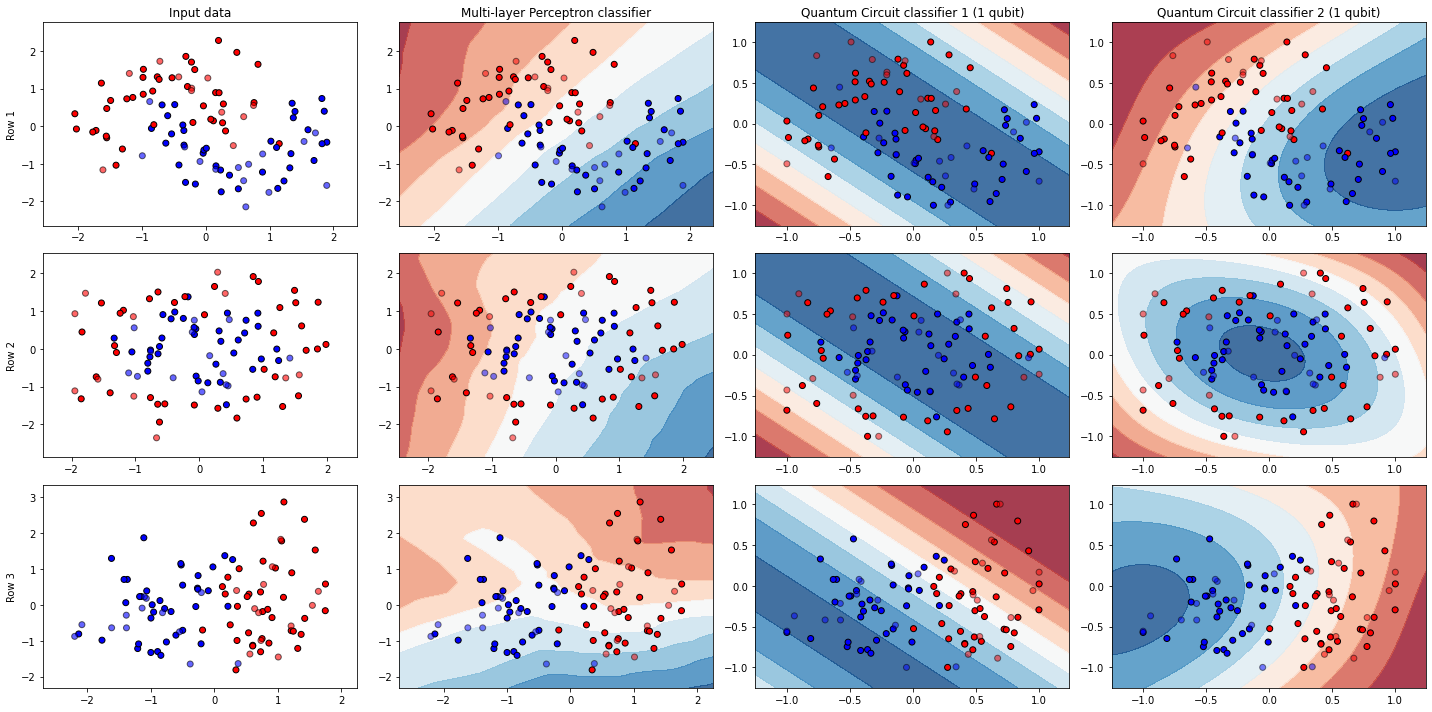

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6819516 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6383108 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5778792 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5152532 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4271700 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3504508 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2755592 | Acc train: 0.4666667 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2112221 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1457736 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0914947 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0469933 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3928220 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3184716 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2617360 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1841600 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1215178 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0589905 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9992057 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9445375 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8993208 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.8673283 | Acc train: 0.6933333 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.8451535 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6986057 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6557681 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6205561 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5612638 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4948728 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4276942 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.3238414 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.2142391 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.0945805 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:    10 | Cost: 0.9832262 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8986552 | Acc trai

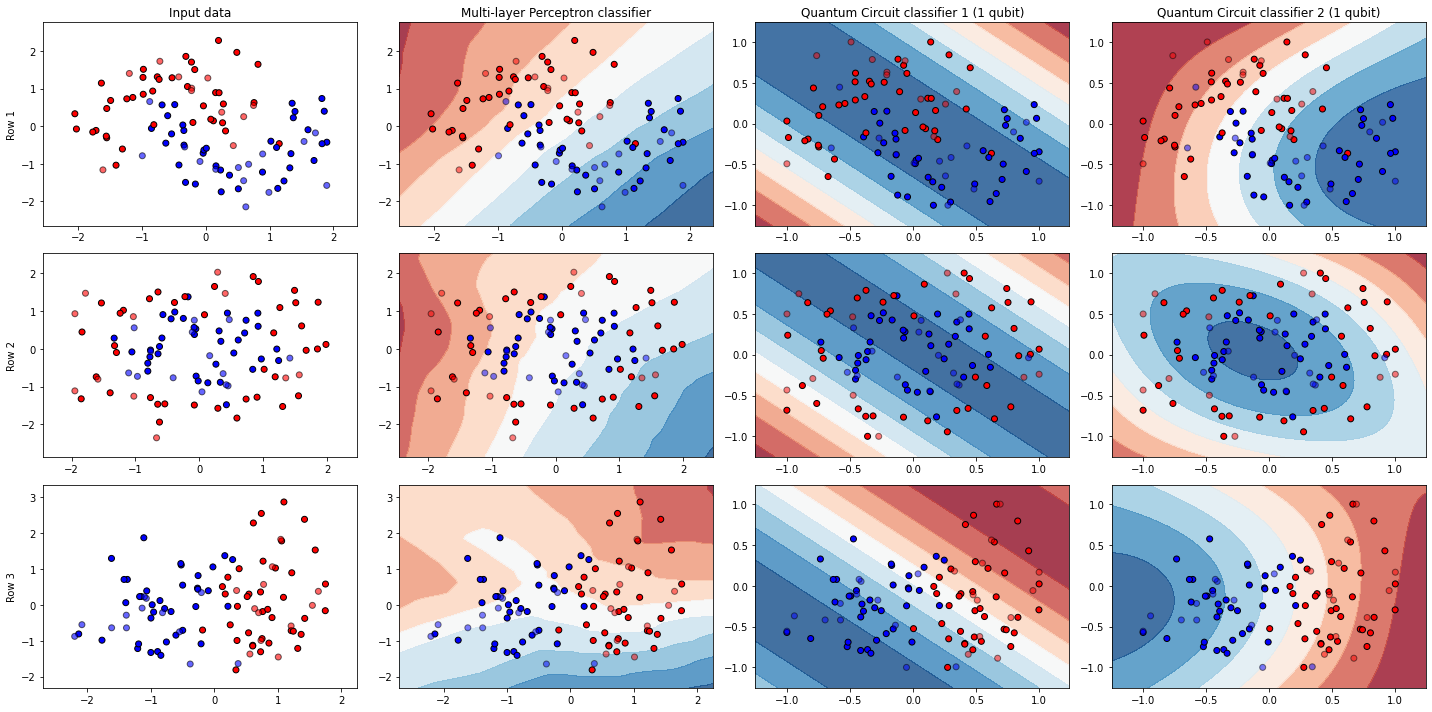

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6671782 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6130251 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5657426 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4885806 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3866545 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.2971410 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2070205 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1423692 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.0991063 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.0602472 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.0369819 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3848117 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3277617 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2671076 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.1962969 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     5 | Cost: 1.1243783 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0551097 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     7 | Cost: 1.0105004 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9776295 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.9528630 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.9413361 | Acc train: 0.6400000 | Acc val: 0.6000000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.9306058 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7076194 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.6608668 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5811923 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5114118 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.4338373 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.3313027 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.2072533 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0676426 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9585540 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8547835 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.7784477 | Acc trai

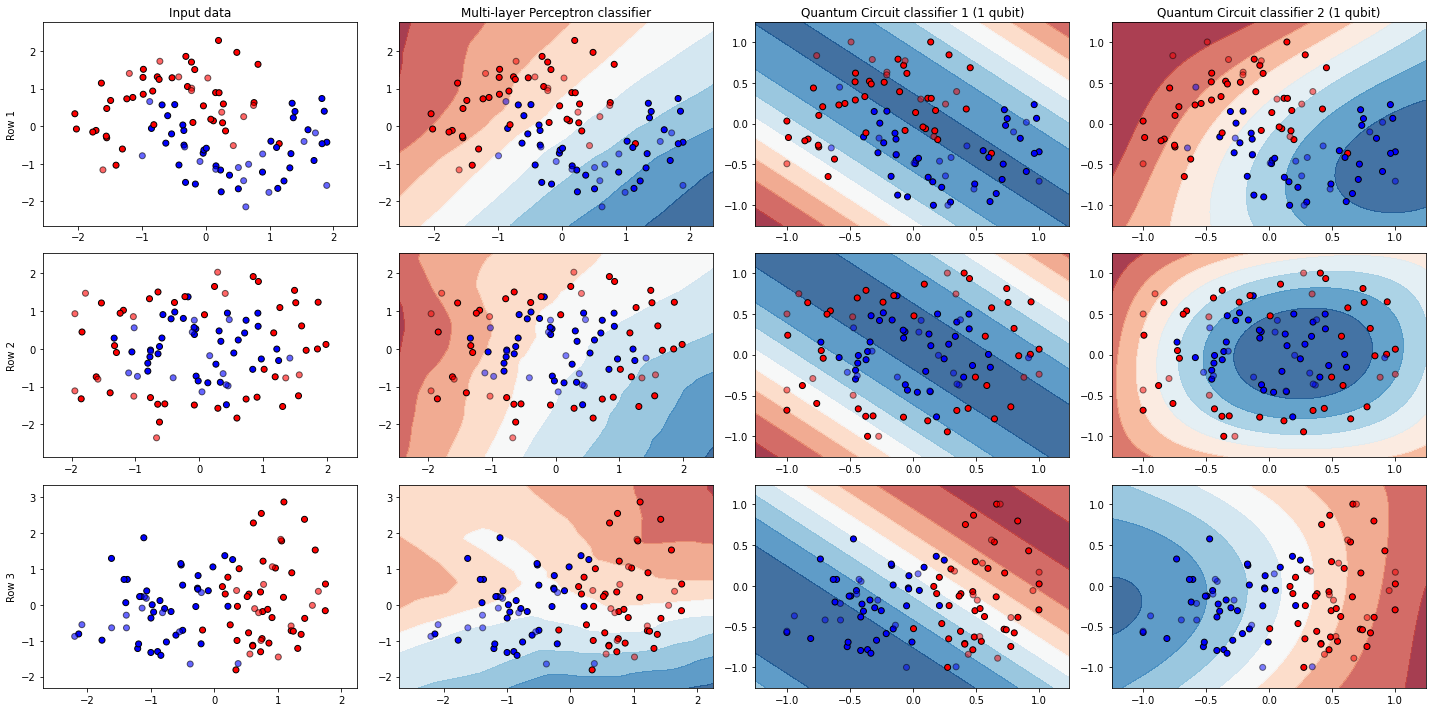

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6727453 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5957557 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5304196 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4656743 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3984869 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3427987 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2875169 | Acc train: 0.4666667 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2403515 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1891435 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.1417420 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.4900000 
Iter:    11 | Cost: 1.1019280 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3713963 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3016849 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2236320 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1434713 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     5 | Cost: 1.0732798 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0064903 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     7 | Cost: 0.9570201 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:     8 | Cost: 0.9204484 | Acc train: 0.6400000 | Acc val: 0.6400000 | Acc all: 0.6600000 
Iter:     9 | Cost: 0.8964729 | Acc train: 0.6533333 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8791946 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:    11 | Cost: 0.8709922 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6893727 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6203791 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5223360 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4279390 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3126150 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.2045724 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0845031 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9768890 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9097049 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8399273 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7722319 | Acc trai

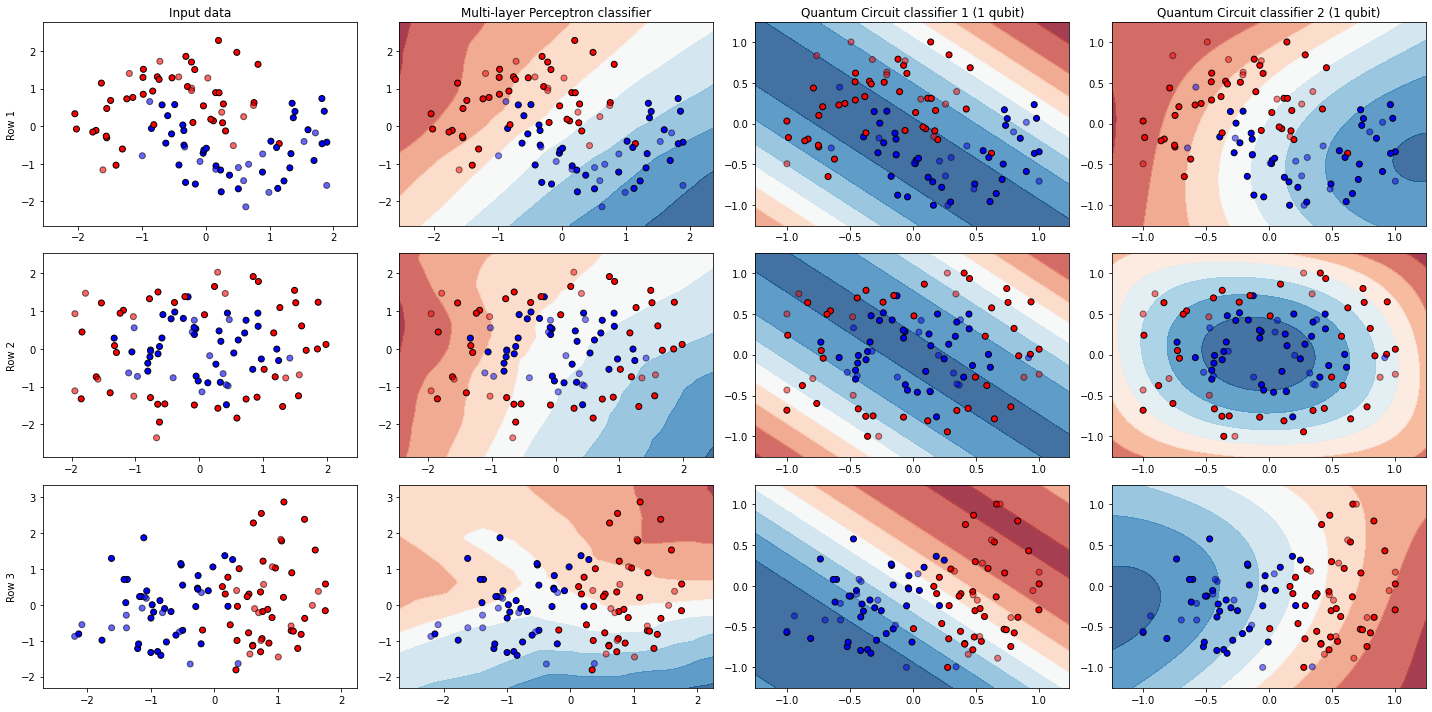

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6585737 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5963706 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5364928 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4702852 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4031856 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.3371179 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2564842 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1910989 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.1430518 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0969401 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0588677 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4047339 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3606629 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3078594 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2406591 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1830585 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1378476 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0876772 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0266635 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9605299 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9099908 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8701008 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7124603 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.6748044 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.6260142 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5518765 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4535238 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.3548233 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.2711784 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.1839721 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.1099320 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.0423165 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6100000 
Iter:    11 | Cost: 0.9459020 | Acc trai

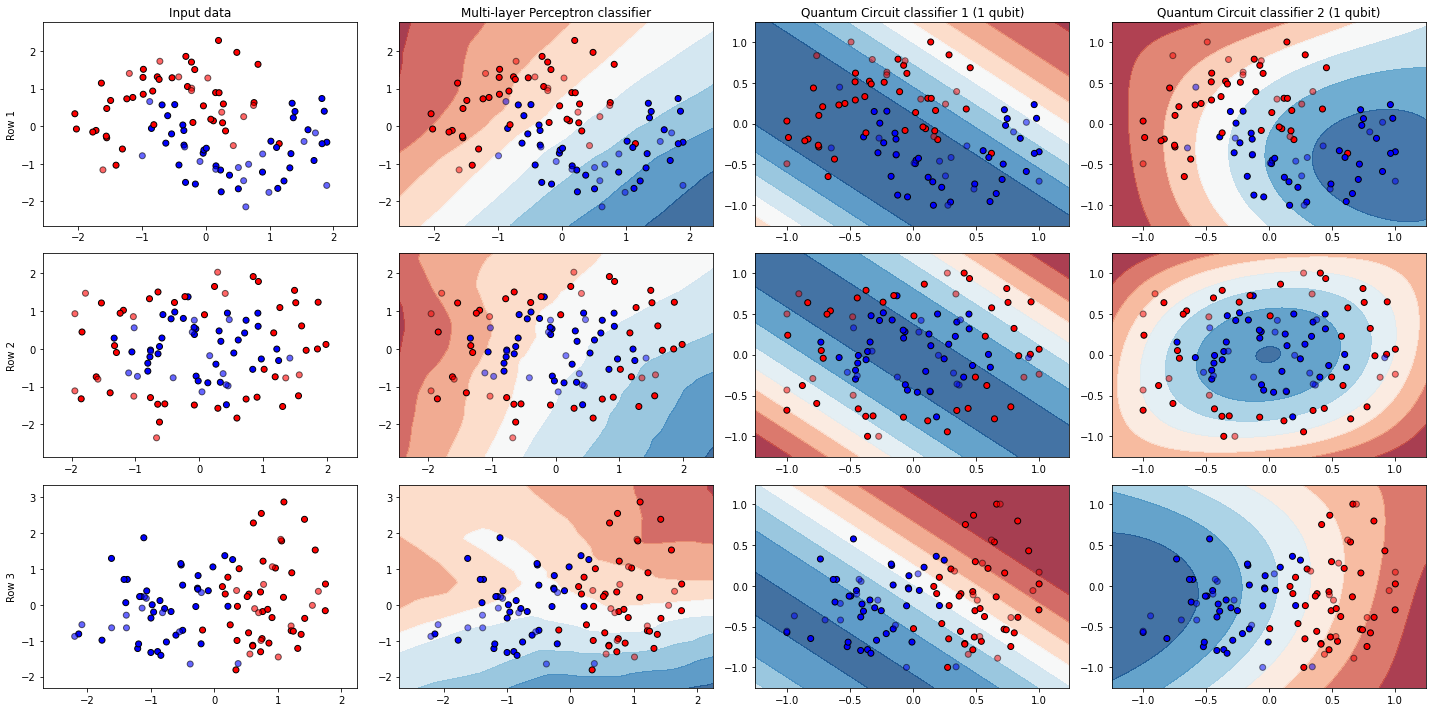

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6777709 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6460787 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5783731 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4992982 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4128311 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.3354386 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2591661 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1884469 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.1310138 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0906737 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.0648468 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4103153 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3819226 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3483466 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2850685 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2179324 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1439157 | Acc train: 0.5466667 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.0605716 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     8 | Cost: 0.9811708 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9076341 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.8580147 | Acc train: 0.6800000 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8337539 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6944637 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.6481134 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5932244 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5084818 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.4118033 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2979127 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1638325 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0447933 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9458965 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8633549 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.7942006 | Acc trai

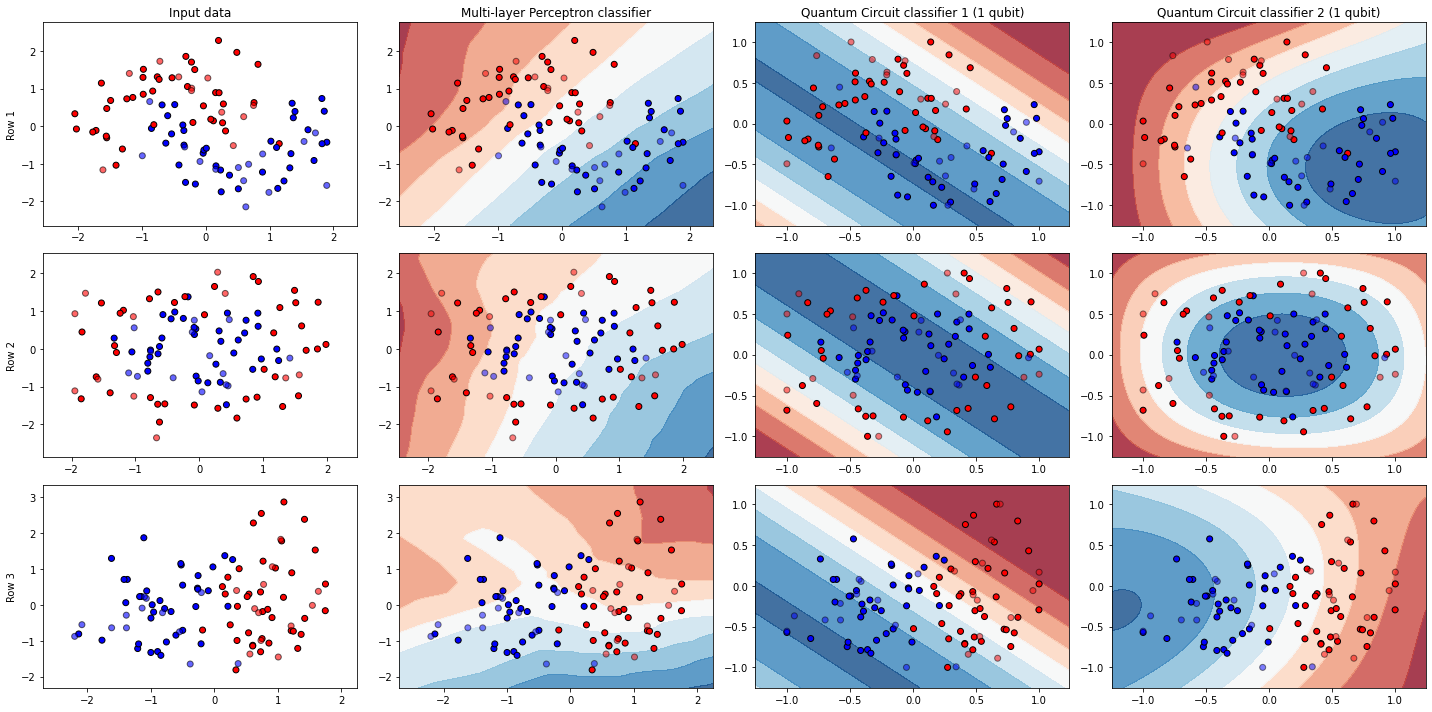

scores: [[[0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]
  [0.76 0.68 0.56]]

 [[0.84 0.72 0.92]
  [0.56 0.76 0.84]
  [0.48 0.72 0.84]
  [0.76 0.76 0.92]
  [0.6  0.6  0.88]
  [0.6  0.76 0.84]
  [0.36 0.68 0.88]
  [0.52 0.68 0.84]
  [0.52 0.64 0.92]
  [0.52 0.6  0.88]
  [0.72 0.72 0.92]
  [0.76 0.76 0.84]
  [0.76 0.8  0.84]]

 [[0.8  0.88 0.92]
  [0.8  0.68 0.88]
  [0.76 0.72 0.92]
  [0.72 0.88 0.84]
  [0.8  0.48 0.92]
  [0.72 0.84 0.92]
  [0.76 0.6  0.88]
  [0.76 0.88 0.92]
  [0.72 0.88 0.92]
  [0.8  0.8  0.92]
  [0.8  0.44 0.92]
  [0.76 0.92 0.92]
  [0.76 0.8  0.92]]]


In [6]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    # "Quantum classifier circuit 1",
    "Quantum Circuit classifier 1 (1 qubit)",
    "Quantum Circuit classifier 2 (1 qubit)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  # [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    linearly_separable, 
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')

  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds
      
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )
      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      #ax.set_xticks(())
      #ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())
            
            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #   xx.max() - 0.3,
            #   yy.min() + 0.3,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
          
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)

In [7]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (1 qubit)
 0: ──RY(1.24)──Rot(-0.0179, 0.692, -0.0152)──RY(1.24)──Rot(0.0162, 0.697, -0.0155)──┤ ⟨Z⟩ 

Quantum Circuit classifier 2 (1 qubit)
 0: ──RY(1.24)──Rot(0.125, 0.474, 0.102)──RX(1.24)──Rot(0.0617, 0.702, 0.00696)──┤ ⟨Z⟩ 



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
